### SSR and FROLs (the greedy algorithms!) examples
There are many algorithms to solve the SINDy regression problem. SSR and FROLs are two popular greedy algorithms. Greedy algorithms iteratively truncate model coefficients, and search for the best model, based on some metric for success. These models work well in practice, but may have weak local convergence and may lack other algorithm guarantees. 

SSR algorithm based on Boninsegna, L., Nüske, F., & Clementi, C. (2018). Sparse learning of stochastic dynamical equations. The Journal of chemical physics, 148(24), 241723 and FROLS algorithm based on Billings, S. A. (2013). Nonlinear system identification: NARMAX methods in the time, frequency, and spatio-temporal domains. John Wiley & Sons.
Jupyter notebook written by Alan Kaptanoglu and Jared Callaham.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/11_SSR_FROLS_examples.ipynb)

Stepwise sparse regression (SSR) solves the problem by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways: (1) truncating the smallest coefficient at each iteration; (2) chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

import pysindy as ps
from pysindy.utils import lorenz

# Ignore odeint warnings when model is unstable
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.filterwarnings("ignore", category=ODEintWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

/var/folders/37/5qnc4jls0l90nkqjm2xxg1bm0000gp/T/ipykernel_86668/2095191201.py:11: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


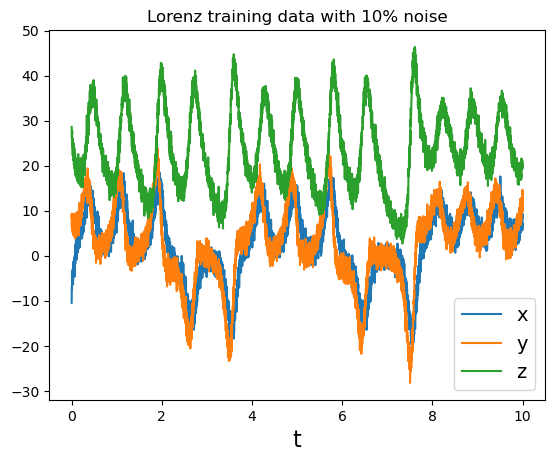

In [2]:
# Generate some training data with added gaussian noise
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)
feature_names = ['x', 'y', 'z']
                    
ssr_optimizer = ps.SSR()

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i], label=feature_names[i])
    
plt.xlabel('t', fontsize=16)
plt.legend(fontsize=14)
plt.title('Lorenz training data with 10% noise')
plt.show()

### Define some functions for plotting performance as the greedy algorithms progress

In [3]:
import matplotlib.gridspec as gridspec

def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)  

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_dot_test_computed[:, i],
                        'k', label='numerical derivative')
            plt.plot(t_test, x_dot_test_predicted[:, i],
                        'r', label='model prediction')
            if j == 0:
                plt.ylabel('$\dot ' + feature_names[i] + r'$', fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, 
                                                     t=dt, 
                                                     metric=mean_squared_error), 
                          fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        model.print()     
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, 
                                                            t=dt, 
                                                            metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

    
def plot_x_fits(x_test, t_test, optimizer, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint 
        # (which just gives a warning)
        # rather than the default solve_ivp, which crashes with an error.
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator='odeint')

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], 'k', label='test trajectory')
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for instability
                plt.plot(t_test, x_test_sim[:, i], 'r', label='model prediction')
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, 
                                                     t=dt, 
                                                     metric=mean_squared_error), 
                          fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
   
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, 
                                                            t=dt, 
                                                            metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

### Note that the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show that we can track the MSE between the predicted and true derivative on a testing trajectory as the algorithm iterates, and then choose the model with the minimum MSE. 

(x0)' = -38.454 1 + 1.105 x0 + 2.041 x1 + 3.923 x2 + 0.441 x0^2 + -0.510 x0 x1 + -0.299 x0 x2 + 0.159 x1^2 + 0.219 x1 x2 + -0.104 x2^2
(x1)' = 23.198 1 + 17.268 x0 + 4.459 x1 + -2.349 x2 + -0.134 x0^2 + 0.100 x0 x1 + -0.719 x0 x2 + -0.024 x1^2 + -0.122 x1 x2 + 0.061 x2^2
(x2)' = 32.497 1 + -7.769 x0 + 5.604 x1 + -6.817 x2 + -0.573 x0^2 + 1.200 x0 x1 + 0.244 x0 x2 + 0.068 x1^2 + -0.186 x1 x2 + 0.135 x2^2
Model 0, MSE: 82.118696
(x0)' = 2.708 1 + 1.392 x0 + 2.503 x1 + -0.428 x2 + 0.233 x0^2 + -0.366 x0 x1 + -0.299 x0 x2 + 0.153 x1^2 + 0.199 x1 x2
(x1)' = 22.863 1 + 17.347 x0 + 4.447 x1 + -2.349 x2 + -0.115 x0^2 + 0.056 x0 x1 + -0.720 x0 x2 + -0.123 x1 x2 + 0.061 x2^2
(x2)' = 33.403 1 + -7.996 x0 + 5.639 x1 + -6.811 x2 + -0.628 x0^2 + 1.325 x0 x1 + 0.247 x0 x2 + -0.183 x1 x2 + 0.136 x2^2
Model 1, MSE: 78.209209
(x0)' = 4.075 1 + 0.872 x0 + 2.575 x1 + -0.343 x2 + 0.113 x0^2 + -0.086 x0 x1 + -0.293 x0 x2 + 0.205 x1 x2
(x1)' = 19.651 1 + 17.230 x0 + 4.455 x1 + -1.868 x2 + -0.040 x0^2 + -0.71

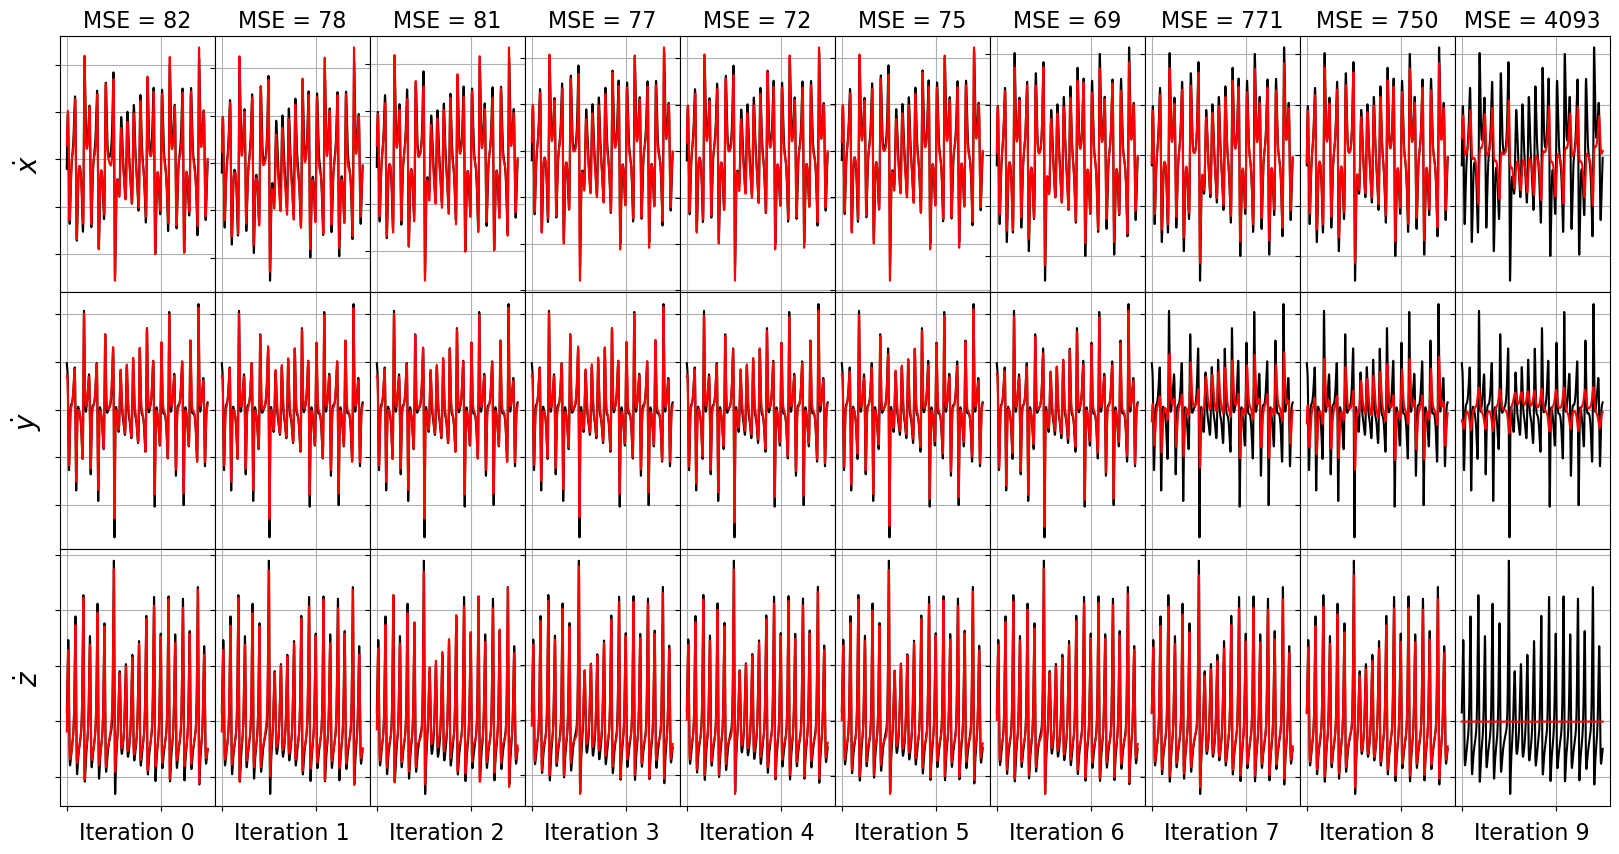

In [4]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T
n_models = 10
plot_x_dot_fits(x_test, ssr_optimizer, dt, n_models)

Model 0, MSE: 82.118696
Model 1, MSE: 78.209209
Model 2, MSE: 81.155077
Model 3, MSE: 77.400572
Model 4, MSE: 71.723637
Model 5, MSE: 74.970460
Model 6, MSE: 68.516681
Model 7, MSE: 771.465636
Model 8, MSE: 750.484221
Model 9, MSE: 4092.533695


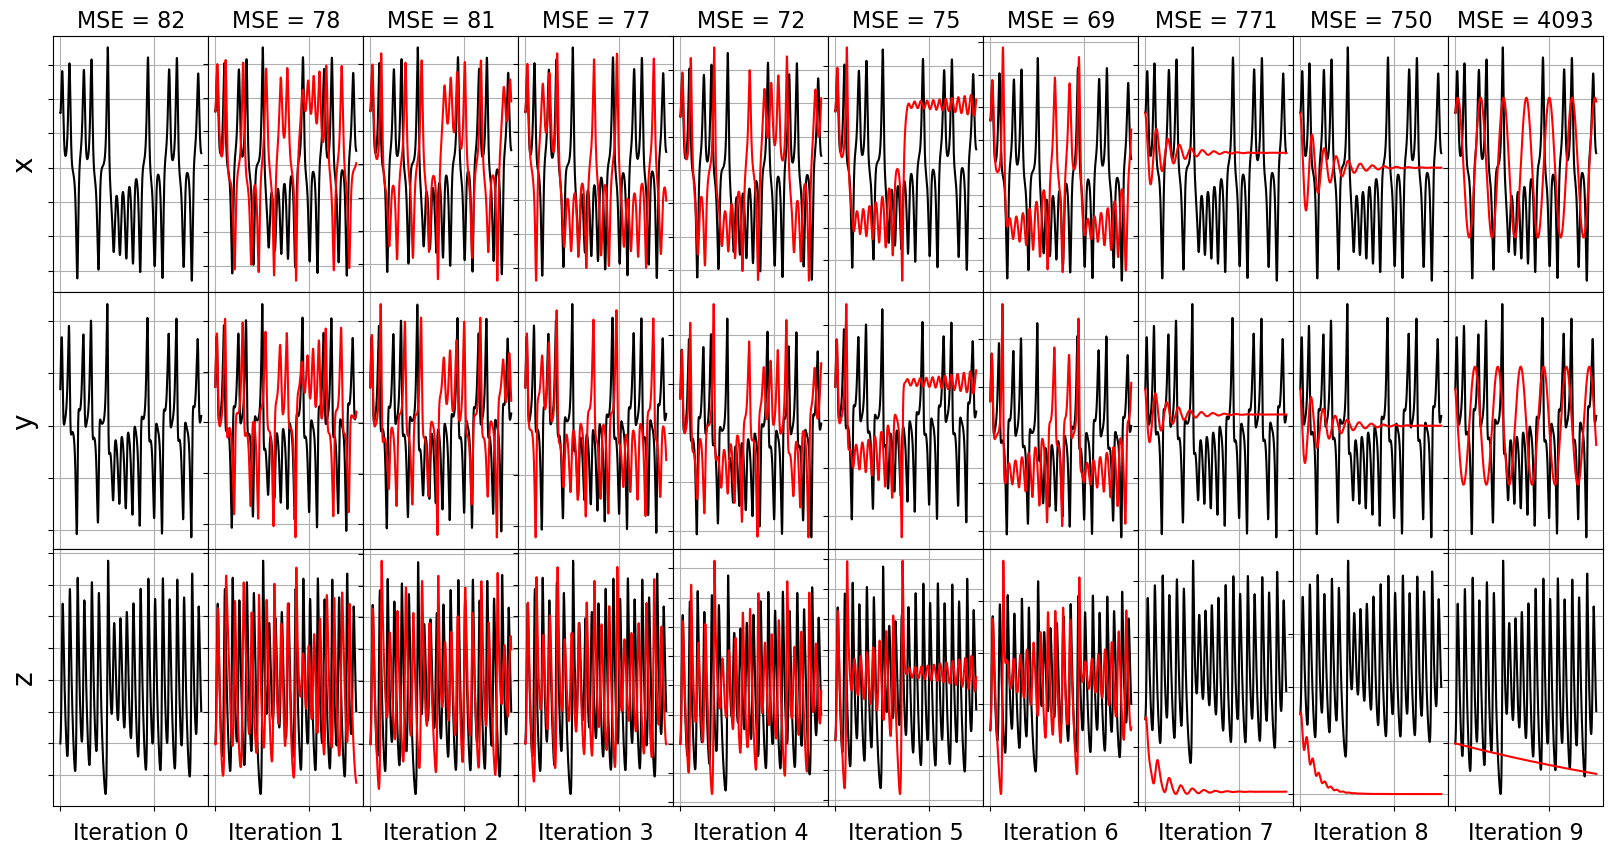

In [5]:
# Repeat plots but now integrate the ODE and compare the test trajectories
plot_x_fits(x_test, t_test, ssr_optimizer, n_models)

Note that some of the frames do not have any red lines... that means the model for this iteration resulted in an unstable model when it was integrated forward. This often happens with nonsparse models!

# Repeat the SSR fitting with the lowest model residual method

In [6]:
ssr_optimizer2 = ps.SSR(criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer2)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

(x0)' = -38.454 1 + 1.105 x0 + 2.041 x1 + 3.923 x2 + 0.441 x0^2 + -0.510 x0 x1 + -0.299 x0 x2 + 0.159 x1^2 + 0.219 x1 x2 + -0.104 x2^2
(x1)' = 23.198 1 + 17.268 x0 + 4.459 x1 + -2.349 x2 + -0.134 x0^2 + 0.100 x0 x1 + -0.719 x0 x2 + -0.024 x1^2 + -0.122 x1 x2 + 0.061 x2^2
(x2)' = 32.497 1 + -7.769 x0 + 5.604 x1 + -6.817 x2 + -0.573 x0^2 + 1.200 x0 x1 + 0.244 x0 x2 + 0.068 x1^2 + -0.186 x1 x2 + 0.135 x2^2
Model 0, MSE: 82.118696
(x0)' = -38.406 1 + 2.692 x1 + 3.944 x2 + 0.442 x0^2 + -0.505 x0 x1 + -0.267 x0 x2 + 0.156 x1^2 + 0.200 x1 x2 + -0.105 x2^2
(x1)' = 22.863 1 + 17.347 x0 + 4.447 x1 + -2.349 x2 + -0.115 x0^2 + 0.056 x0 x1 + -0.720 x0 x2 + -0.123 x1 x2 + 0.061 x2^2
(x2)' = 33.403 1 + -7.996 x0 + 5.639 x1 + -6.811 x2 + -0.628 x0^2 + 1.325 x0 x1 + 0.247 x0 x2 + -0.183 x1 x2 + 0.136 x2^2
Model 1, MSE: 76.632609
(x0)' = -36.278 1 + 2.463 x1 + 3.942 x2 + 0.315 x0^2 + -0.217 x0 x1 + -0.277 x0 x2 + 0.215 x1 x2 + -0.103 x2^2
(x1)' = 19.651 1 + 17.230 x0 + 4.455 x1 + -1.868 x2 + -0.040 x0^2

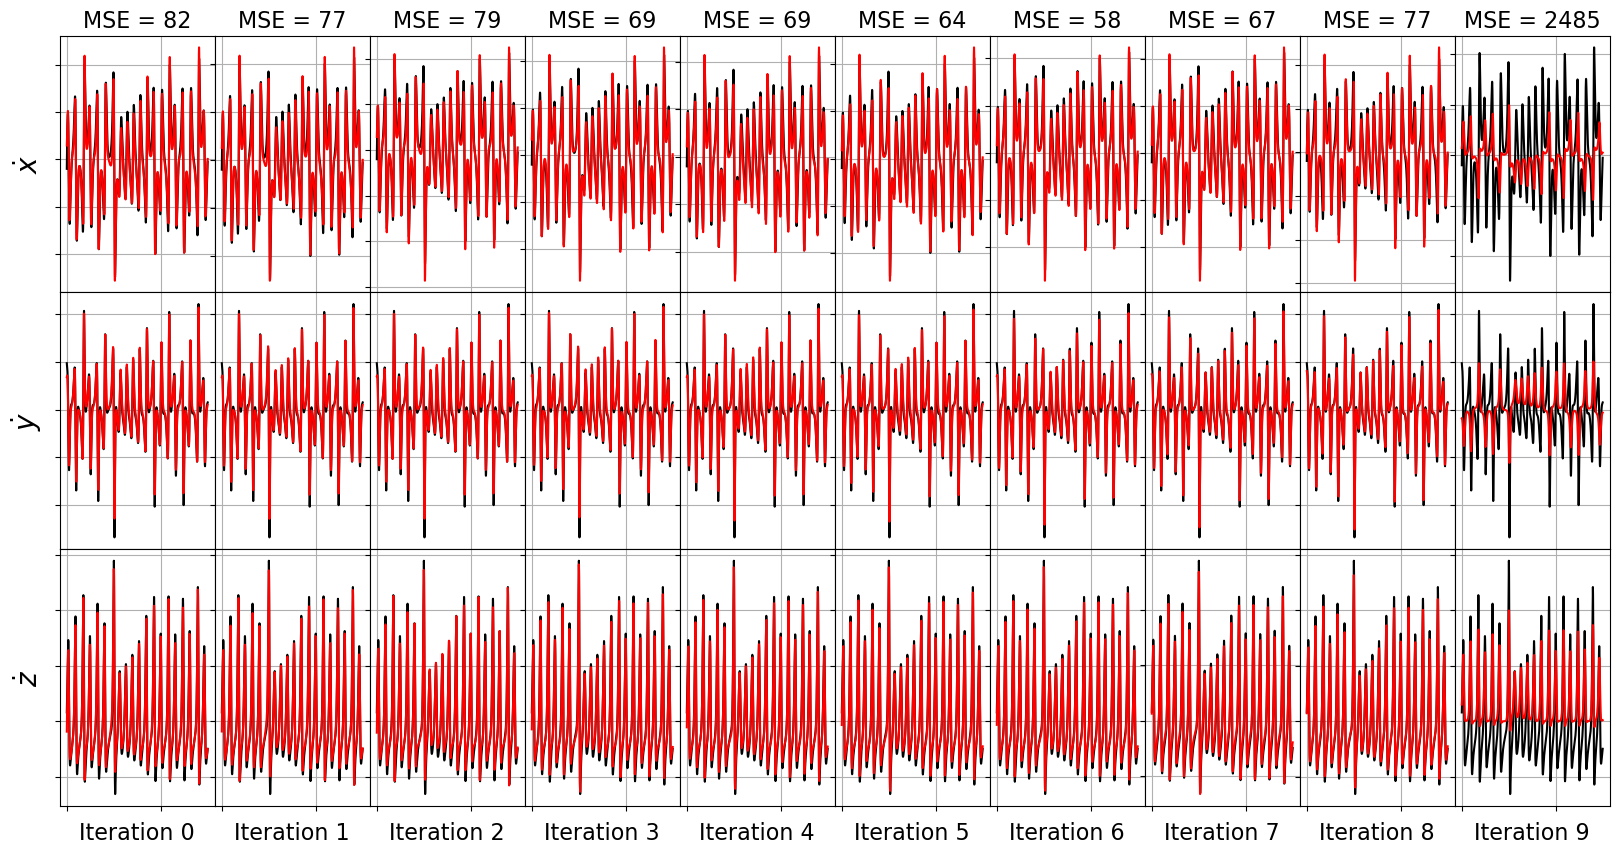

In [7]:
plot_x_dot_fits(x_test, ssr_optimizer2, dt, n_models)

Model 0, MSE: 82.118696
Model 1, MSE: 76.632609
Model 2, MSE: 79.031733
Model 3, MSE: 69.127604
Model 4, MSE: 69.096209
Model 5, MSE: 63.600464
Model 6, MSE: 57.569520
Model 7, MSE: 66.738381
Model 8, MSE: 77.045027
Model 9, MSE: 2484.769705


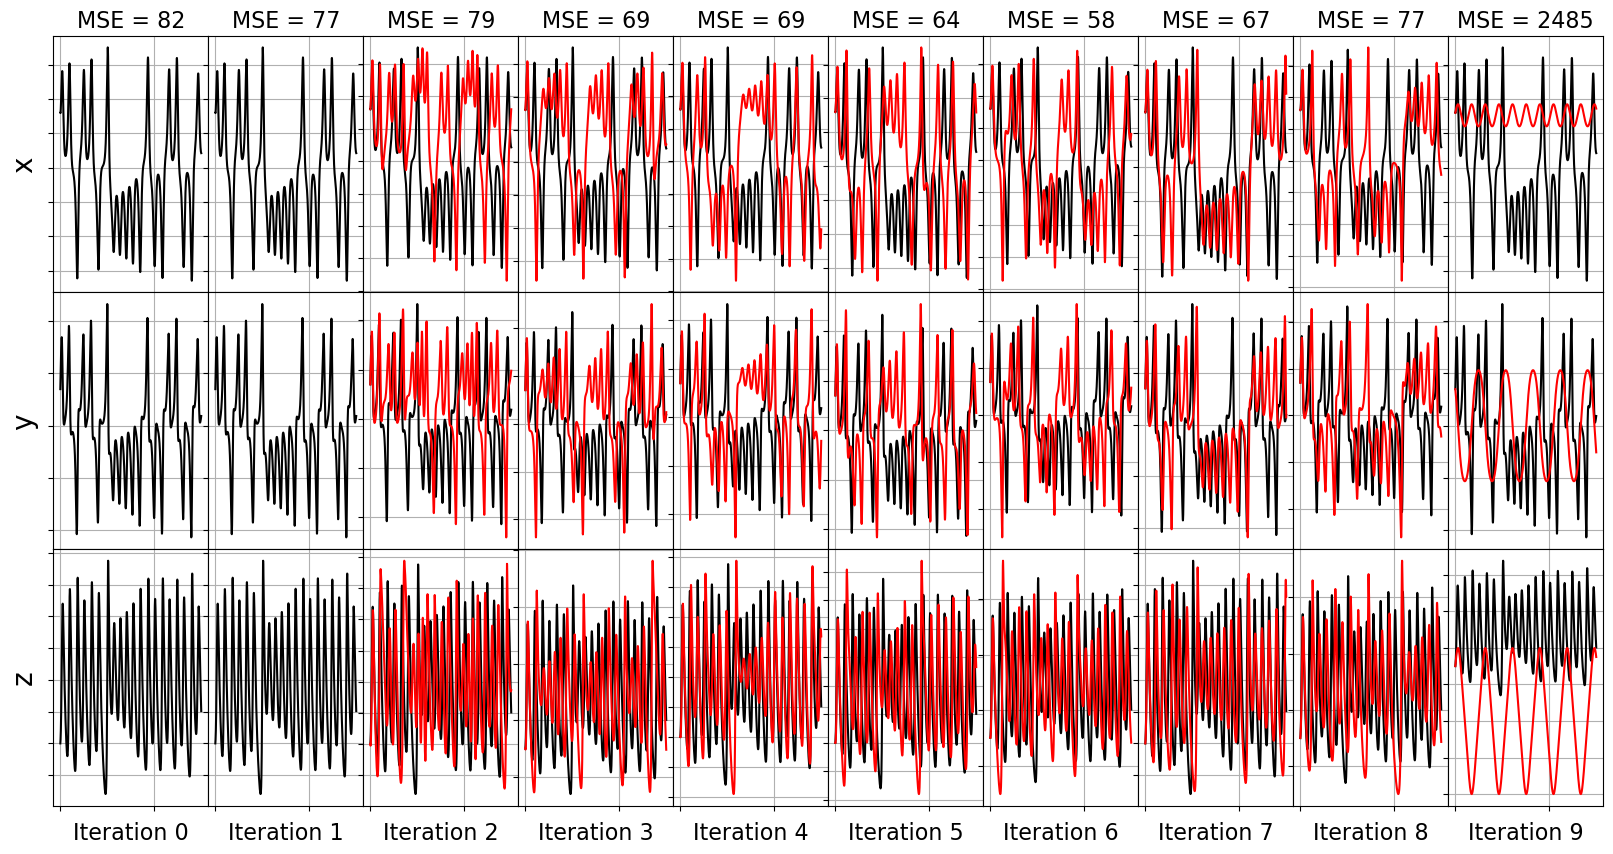

In [8]:
plot_x_fits(x_test, t_test, ssr_optimizer2, n_models)

# FROLS greedy algorithm
Forward Regression Orthogonal Least Squares (FROLS) solves the least-squares regression problem with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis.
### Note that (at least our implementation) performs poorly on noise, generating more unstable models than SSR. FROLs is also different from FROLs because it starts with no coefficients and then at each iteration adds a new nonzero coefficient.

In [9]:
frols_optimizer = ps.FROLS()

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=FROLS())

(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
Model 0, MSE: 4453.379811
(x0)' = 2.215 x1
(x1)' = -0.146 x0 x2
(x2)' = 0.388 x1^2
Model 1, MSE: 2384.566975
(x0)' = -7.872 x0 + 7.805 x1
(x1)' = 22.193 x0 + -0.809 x0 x2
(x2)' = -50.920 1 + 0.596 x1^2
Model 2, MSE: 268.880514
(x0)' = 1.218 x0 + 6.237 x1 + -0.258 x0 x2
(x1)' = 16.269 x0 + 2.815 x1 + -0.705 x0 x2
(x2)' = -29.291 1 + -5.402 x0 x1 + 4.176 x1^2
Model 3, MSE: 8274.713196
(x0)' = 0.099 x0 + 0.223 x1 + -0.297 x0 x2 + 0.322 x1 x2
(x1)' = 9.417 x0 + 10.364 x1 + -0.451 x0 x2 + -0.322 x1 x2
(x2)' = -2.251 1 + -2.414 x0^2 + 3.434 x0 x1 + -0.654 x1^2
Model 4, MSE: 1149.203212
(x0)' = -1.946 1 + 0.103 x0 + 0.222 x1 + -0.296 x0 x2 + 0.324 x1 x2
(x1)' = 1.219 x0 + 2.156 x1 + -0.528 x0 x2 + 0.022 x1 x2 + 0.316 x2^2
(x2)' = -0.665 1 + -1.707 x2 + -0.741 x0^2 + 1.526 x0 x1 + -0.081 x1^2
Model 5, MSE: 22799.993817
(x0)' = -0.009 1 + 0.104 x0 + 0.222 x1 + -0.035 x0 x1 + -0.295 x0 x2 + 0.324 x1 x2
(x1)' = 1.219 x0 + 2.156 x1 + -0.005 x0^2 + -0.528 x

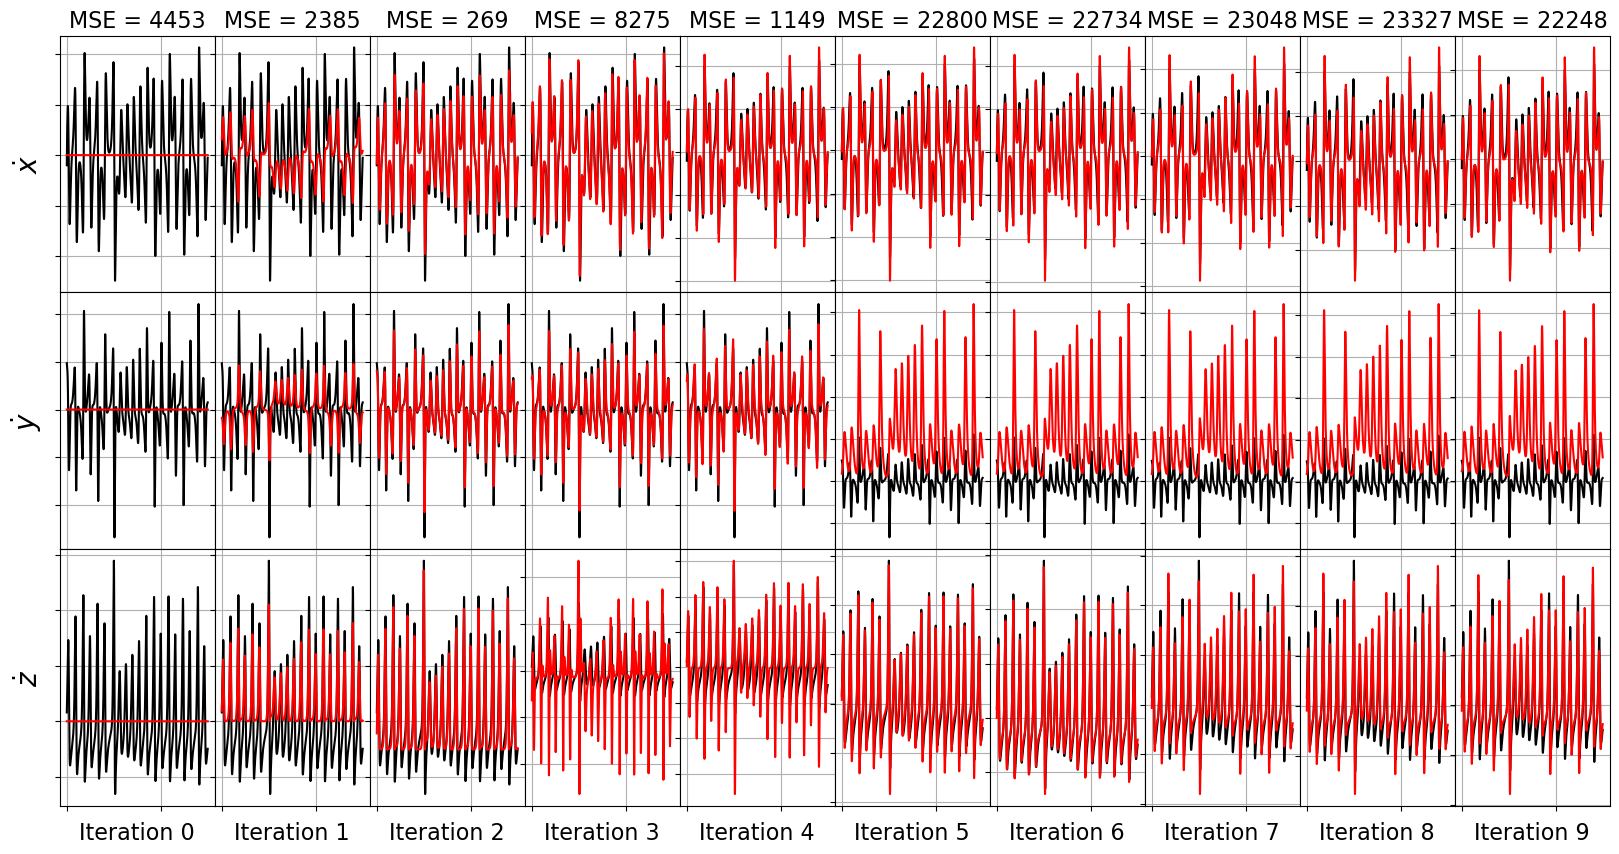

In [10]:
plot_x_dot_fits(x_test, frols_optimizer, dt, n_models)

Model 0, MSE: 4453.379811
Model 1, MSE: 2384.566975
Model 2, MSE: 268.880514
Model 3, MSE: 8274.713196
Model 4, MSE: 1149.203212
Model 5, MSE: 22799.993817
Model 6, MSE: 22734.433754
Model 7, MSE: 23048.431824
Model 8, MSE: 23326.682231
Model 9, MSE: 22248.241095


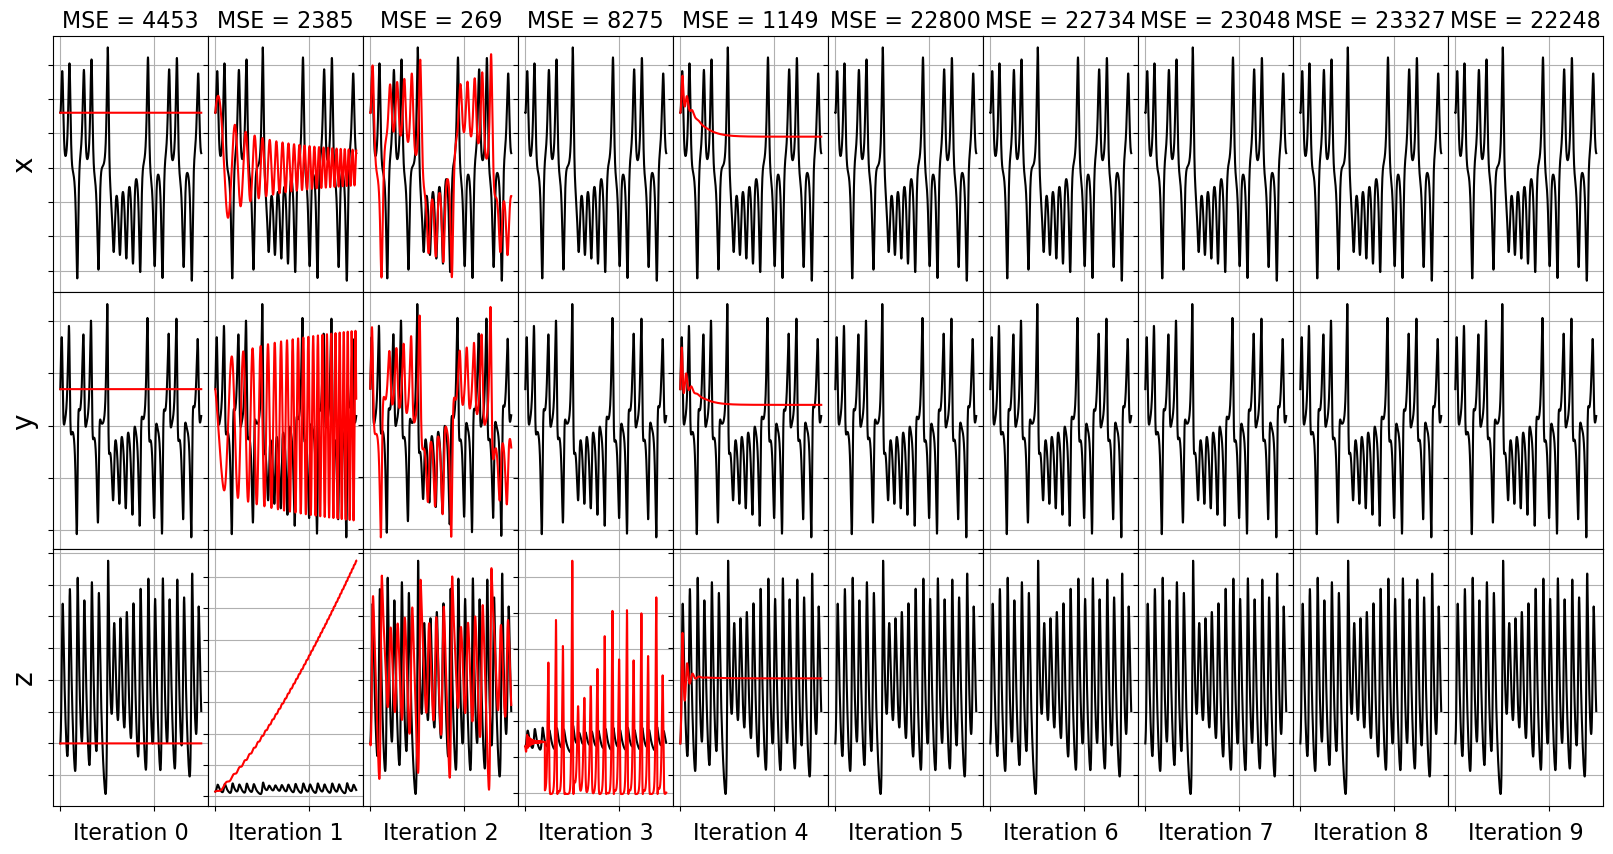

In [11]:
plot_x_fits(x_test, t_test, frols_optimizer, n_models)

### Let's compare all three methods as the noise steadily increases, cross-validated over 10 noise instantiations

Text(0.5, 1.0, 'Comparison of highest performance SSR and FROLs models,\n averaged over 10 models trained on different noise')

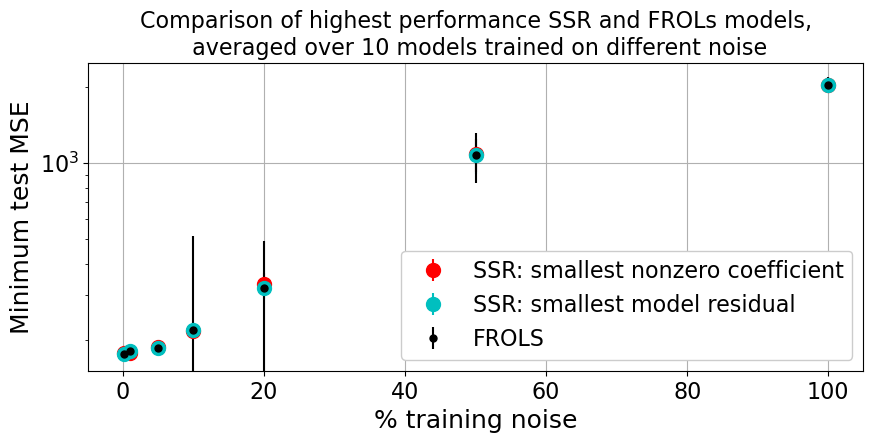

In [12]:
# generate training and testing data
dt = .1
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T

# Cross-validate over 10 discharges for each noise level
n_validation = 10
noise_levels = [rmse / 1000.0, rmse / 100.0, rmse / 20.0, 
                rmse / 10.0, rmse / 5.0, rmse / 2.0, rmse]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((3, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.normal(0, noise_level, x_train.shape)
        for kk in range(3): 
            if kk == 0:
                optimizer = ps.SSR(criteria="coefficient_value")
            if kk == 1:
                optimizer = ps.SSR(criteria="model_residual")
            if kk == 2:
                optimizer = ps.FROLS()
            model = ps.SINDy(optimizer=optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(optimizer.history_)[0])
            for j in range(np.shape(optimizer.history_)[0]):
                optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)
            
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)

# Plot average MSE results with error bars.
# Note we are not including a sparsity penalty in the error term.
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', markersize=10,
             label='SSR: smallest nonzero coefficient')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='c', markersize=10,
             label='SSR: smallest model residual')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[2, :], fmt='o', color='k', markersize=5,
             label='FROLS')
plt.yscale('log')
plt.legend(fontsize=16, loc='lower right', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
plt.xlabel('% training noise', fontsize=18)
plt.ylabel('Minimum test MSE', fontsize=18)
plt.title('Comparison of highest performance SSR and FROLs models,\n '
          'averaged over 10 models trained on different noise', fontsize=16)

### Summary
To summarize the findings here, SSR seems to substantially outperform FROLs, at least on this noisy and chaotic data. The "best model" (as measured by the minimal MSE on a testing trajectory) for FROLs often competes with the SSR "best model", but usually with much higher variance. Moreover, almost all the SSR models outperform the FROLs models at the same level of sparsity! So we strongly recommend that on noisy, chaotic data, one uses STLSQ or SSR. The advantage of using SSR is that no hyperparameters are necessarily needed, although one has to choose a favorite or best model at the end. 